In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from astropy.table import Table
import astropy.io.fits as fits

from scipy.optimize import curve_fit

from glob import glob

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

from astropy.stats import LombScargle
from stuff import FINDflare

In [3]:
tess_dir = '/data/epyc/data/tess/'

sectors = ['sector001', 'sector002']

# just in case glob wants to re-order things, be sure grab them in Sector order
sect1 = glob(tess_dir + sectors[0] + '/*.fits', recursive=True)
sect2 = glob(tess_dir + sectors[1] + '/*.fits', recursive=True)

files = sect1 + sect2
print(len(sect1), len(sect2), len(files))

15889 15990 31879


/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


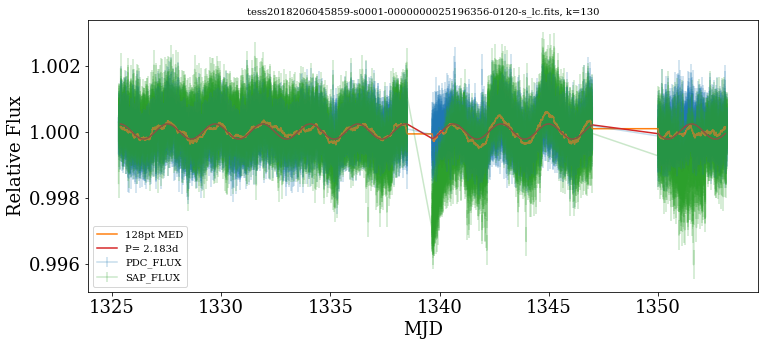

0.00019965769824934097 9.701609195315509e-05


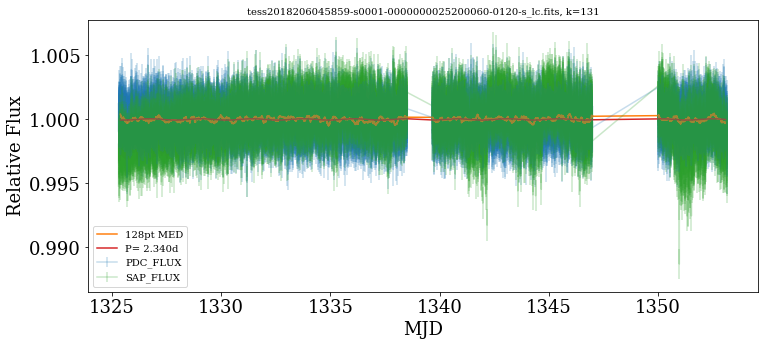

0.00015375936607046843 0.0007025261323887996


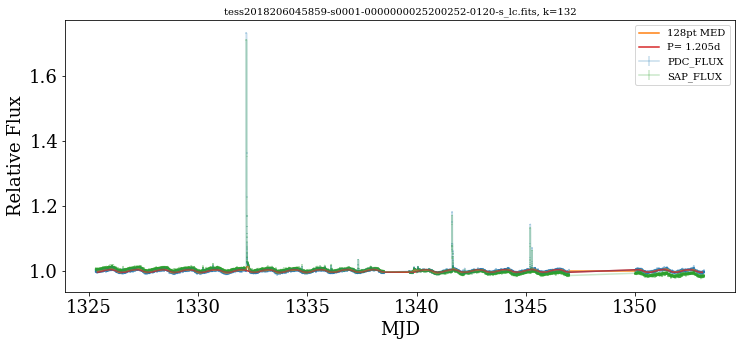

0.003336792177524198 0.00011914945548548744


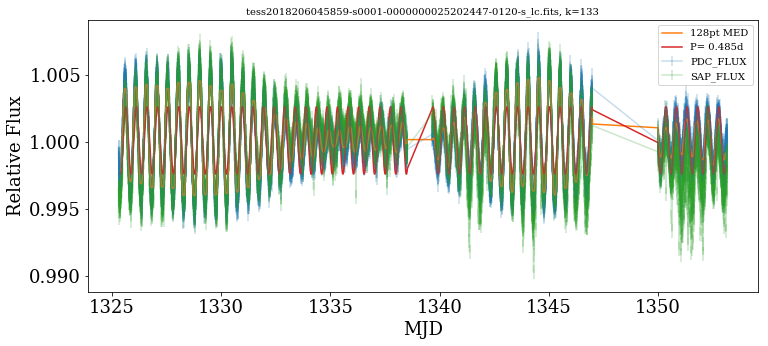

0.0021909868108525273 4.187679738204245e-05


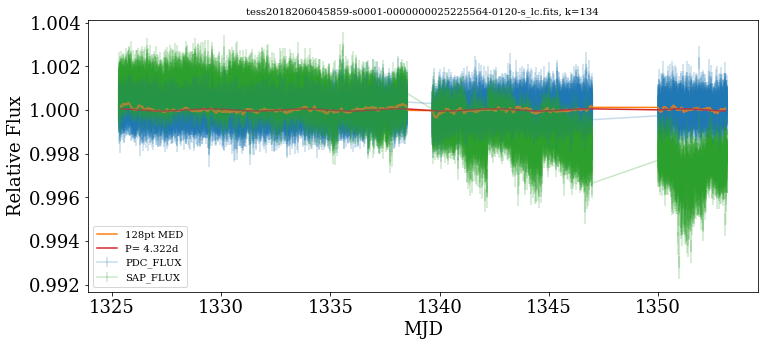

8.962792339638663e-05 0.00035463794426583044


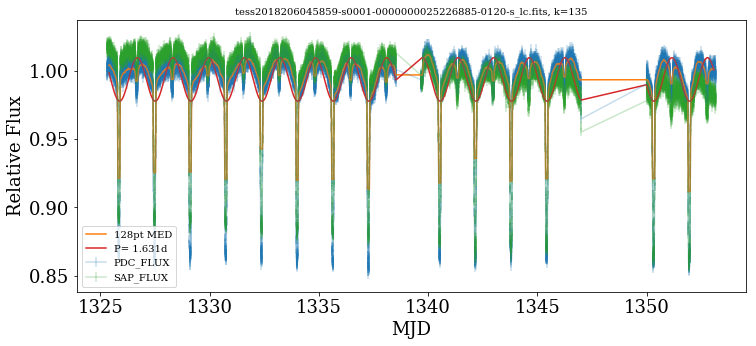

0.019776753755056928 0.00043242080676169476


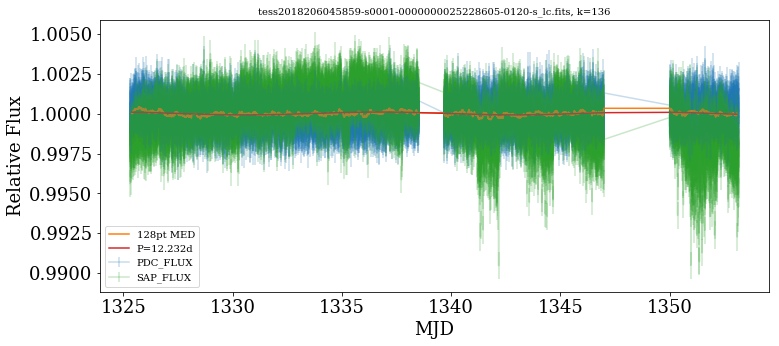

0.00012638534602477973 0.0005132334425435941


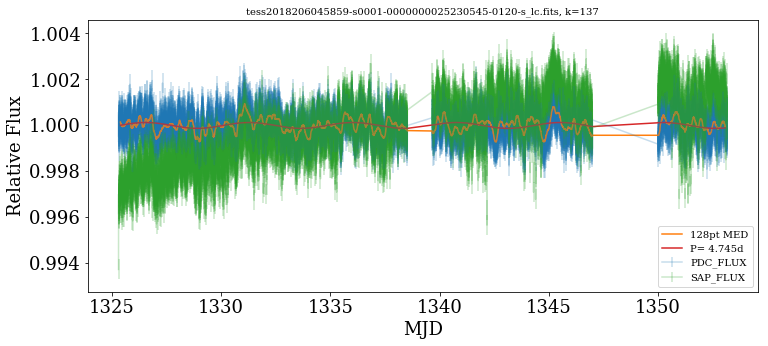

0.00028594571099143723 0.0001545760440906519


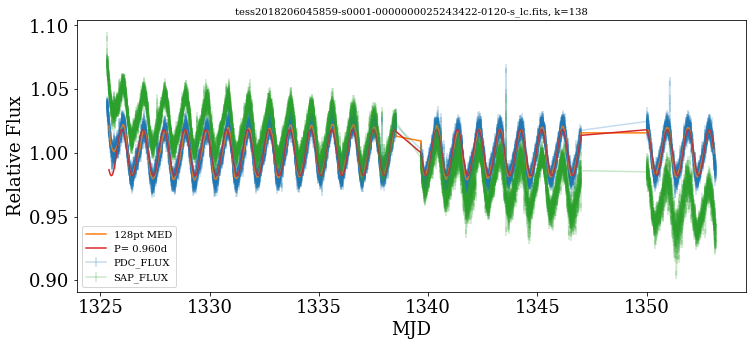

0.0133203303994559 5.063341833722439e-05


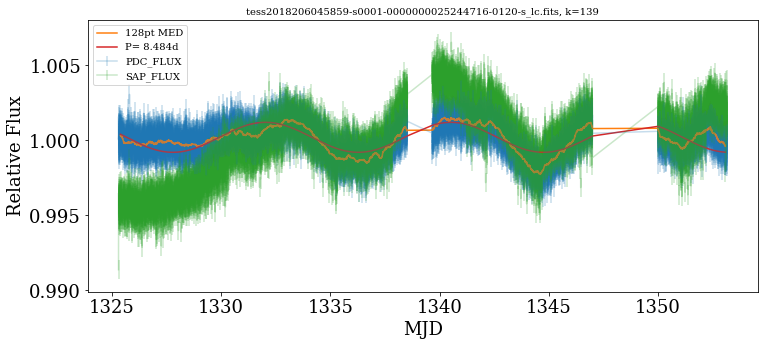

0.0008681536781800917 3.6694066932088376e-05


In [5]:
# lets look at some random LCs
for k in range(130,140):
    try:
        tbl = Table.read(files[k], format='fits')
        df = tbl.to_pandas()
        AOK = (tbl['QUALITY'] == 0) & ((tbl['TIME'] < 1347) | (tbl['TIME'] > 1350))
        
        if sum(AOK) > 10:
            # do a running median for a basic smooth
            smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
            med = np.nanmedian(smo)
            
            #find OK points in the smoothed LC
            SOK = np.isfinite(smo)

            
            LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
            frequency, power = LS.autopower(minimum_frequency=1./40., 
                                            maximum_frequency=1./0.1, 
                                            samples_per_peak=7)
            best_frequency = frequency[np.argmax(power)]

            plt.figure(figsize=(12,5))
            plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK]/med, yerr=tbl['PDCSAP_FLUX_ERR'][AOK]/med, 
                         linestyle=None, alpha=0.25, label='PDC_FLUX')
            plt.plot(tbl['TIME'][AOK], smo/med, label='128pt MED')
            
            Smed = np.nanmedian(tbl['SAP_FLUX'][AOK])
            plt.errorbar(tbl['TIME'][AOK], tbl['SAP_FLUX'][AOK]/Smed, yerr=tbl['SAP_FLUX_ERR'][AOK]/Smed, 
                         linestyle=None, alpha=0.25, label='SAP_FLUX')

            LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
            plt.plot(df['TIME'][AOK][SOK], LSmodel, label='P='+format(1./best_frequency, '6.3f')+'d')            

            
            plt.title(files[k].split('/')[-1]+', k='+str(k) , fontsize=10)
            plt.ylabel('Relative Flux')
            plt.xlabel('MJD')
            plt.legend(fontsize=10)
            plt.savefig('figures/' + files[k].split('/')[-1] + '.jpeg', bbox_inches='tight', pad_inches=0.25)
            plt.show()
            
            print(np.nanstd(smo/med), np.nanmedian(power))

            
    except (OSError, KeyError, TypeError):
        print('k=' + str(k) + ' bad file: ' + files[k])

In [6]:
len(files)

31879

In [ ]:
%%time
per_out = np.zeros(len(files)) -1 
per_amp = np.zeros(len(files)) -1 
per_med = np.zeros(len(files)) -1 

FL_id = np.array([])
FL_t0 = np.array([]) 
FL_t1 = np.array([])
FL_f0 = np.array([])
FL_f1 = np.array([])

for k in range(len(files)):
    try:
        tbl = Table.read(files[k], format='fits')
        df = tbl.to_pandas()
        
        # make harsh quality cuts, and chop out a known bad window of time
        AOK = (tbl['QUALITY'] == 0) & ((tbl['TIME'] < 1347) | (tbl['TIME'] > 1350))
        
        if sum(AOK) > 10:
            # do a running median for a basic smooth
            smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
            med = np.nanmedian(smo)
            
            #find OK points in the smoothed LC
            SOK = np.isfinite(smo)

            
            FL = FINDflare((df['PDCSAP_FLUX'][AOK][SOK] - smo[SOK])/med, 
                           df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
                           N1=3, N2=1, N3=4)


            LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
            frequency, power = LS.autopower(minimum_frequency=1./40., 
                                            maximum_frequency=1./0.1, 
                                            samples_per_peak=7)
            best_frequency = frequency[np.argmax(power)]

            per_out[k] = 1./best_frequency
            per_amp[k] = np.nanmax(power)
            per_med[k] = np.nanmedian(power)

            if np.size(FL) > 0:
                for i in range(len(FL[0])):
                    FL_id = np.append(FL_id, k)
                    FL_t0 = np.append(FL_t0, FL[0][i])
                    FL_t1 = np.append(FL_t1, FL[1][i])
                    FL_f0 = np.append(FL_f0, med)
                    FL_f1 = np.append(FL_f1, np.nanmax(tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)]))


            # make output plots?
            if True:
                plt.figure(figsize=(12,9))

                plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK]/med, yerr=tbl['PDCSAP_FLUX_ERR'][AOK]/med, 
                             linestyle=None, alpha=0.25, label='PDC_FLUX')
                plt.plot(tbl['TIME'][AOK], smo/med, label='128pt MED')

                Smed = np.nanmedian(tbl['SAP_FLUX'][AOK])
                plt.errorbar(tbl['TIME'][AOK], tbl['SAP_FLUX'][AOK]/Smed, yerr=tbl['SAP_FLUX_ERR'][AOK]/Smed, 
                             linestyle=None, alpha=0.25, label='SAP_FLUX')

            
                if np.size(FL) > 0:
                    for i in range(len(FL[0])):
                        plt.scatter(tbl['TIME'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], 
                                    tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], color='r', 
                                    label='_nolegend_')

                if np.nanmax(power) > 0.2:
                    LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
                    plt.plot(df['TIME'][AOK][SOK], LSmodel, label='P='+format(1./best_frequency, '6.3f')+'d')            

                plt.title(files[k].split('/')[-1], fontsize=12)
                plt.ylabel('Flux')
                plt.xlabel('MJD')
                plt.legend(fontsize=10)
#                 plt.show()
                plt.savefig('figures/' + files[k].split('/')[-1] + '.jpeg', bbox_inches='tight', pad_inches=0.25)
                plt.close()
        
    except (OSError, KeyError, TypeError):
        print('k=' + str(k) + ' bad file: ' + files[k])

/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/epyc/opt/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


k=3309 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000139804925-0120-s_lc.fits
k=4172 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000147302681-0120-s_lc.fits


In [ ]:
Nfl, Bfl, Pt = plt.hist((FL_t0+FL_t1)/2.,bins=200)

plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')

In [ ]:
_ = plt.hist(np.log10(Nfl), bins=100)
# plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.figure(figsize=(9,7))
s1 = np.where((FL_id < 15000))[0]
s2 = np.where((FL_id > 16000))[0]

_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=150, alpha=0.5, label='sector001')
_ = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=150, alpha=0.5, label='sector002')

# plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')
plt.savefig('flare_hist.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
ALL_TIC = pd.Series(files).str.split('-', expand=True).iloc[:,-3].astype('int')

In [ ]:
flare_out = pd.DataFrame(data={'TIC':ALL_TIC[FL_id], 'i0':FL_t0, 'i1':FL_t1, 'med':FL_f0, 'peak':FL_f1})
flare_out.to_csv('flare_out_v01.csv')

In [ ]:
rot_out = pd.DataFrame(data={'TIC':ALL_TIC, 
                             'per':per_out, 'Pamp':per_amp, 'Pmed':per_med})
rot_out.to_csv('rot_out_v01.csv')

In [ ]:
# ffok = np.isfinite(flare_out['peak']) & np.isfinite(flare_out['med'])
# _ = plt.hist(np.log10(flare_out['peak'][ffok]/flare_out['med'][ffok]),bins=100)
# plt.xlabel('log (Flare Peak / LC Median)')
# plt.yscale('log')

In [ ]:
# _ = plt.hist(flare_out['TIC'],bins=100)
uTIC, NTIC = np.unique(flare_out['TIC'].values, return_counts=True)
imax = np.argmax(NTIC)
print(uTIC[imax], NTIC[imax])

In [ ]:
# kk = np.where((ALL_TIC == uTIC[imax]))[0]

# for k in kk:
#     tbl = Table.read(files[k], format='fits')
#     df = tbl.to_pandas()
#     AOK = tbl['QUALITY'] == 0
#     if sum(AOK) > 10:
#         smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
#         med = np.nanmedian(smo)
#         SOK = np.isfinite(smo)

#         FL = FINDflare((df['PDCSAP_FLUX'][AOK][SOK] - smo[SOK])/med, df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
#                        N1=3, N2=1, N3=3)


#         LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
#         frequency, power = LS.autopower(minimum_frequency=1./20., maximum_frequency=1./0.1)
#         best_frequency = frequency[np.argmax(power)]


#         # make output plots?
#         plt.figure(figsize=(12,9))
#         plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK], yerr=tbl['PDCSAP_FLUX_ERR'][AOK], 
#                      linestyle=None, alpha=0.25, label='PDCFLUX')

#         plt.plot(tbl['TIME'][AOK], smo, label='128pt MED')
#         if np.size(FL) > 0:
#             for i in range(len(FL[0])):
#                 plt.scatter(tbl['TIME'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], 
#                             tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], color='r', label='_nolegend_')

#         if np.nanmax(power) > 0.25:
#             LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
#             plt.plot(df['TIME'][AOK][SOK], LSmodel * med, label='P='+format(1./best_frequency, '6.3f')+'d')            

#         plt.title(files[k].split('/')[-1], fontsize=12)
#         plt.ylabel('Flux')
#         plt.xlabel('MJD')
#         plt.legend(fontsize=12)
#         plt.show()
#             # plt.savefig('test1.jpeg', bbox_inches='tight', pad_inches=0.25)

In [ ]:
# NOW MATCH OUTPUT TO GAIA FILE, PLOT ROTATION ON THE CMD, AND PROT VS COLOR

In [ ]:
df1 = pd.read_csv(tess_dir + 'gaiatess1_xmatch_1arsec-result.csv')
df2 = pd.read_csv(tess_dir + 'gaiatess2_xmatch_1arsec-result.csv')

In [ ]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)

In [ ]:
gdata = pd.merge(df, rot_out, right_on='TIC', left_on='ticid')

In [ ]:
# gdata.columns.values

In [ ]:
ok = np.where(np.isfinite(gdata[u'parallax']) & # this is basically the same as the TGAS file...
              (gdata[u'parallax_error'] / gdata[u'parallax'] < 0.1) &
              (gdata[u'modality_flag'] == 1) & 
              (gdata[u'result_flag'] == 1) &
              np.isfinite(gdata[u'bp_rp']) & 
              (gdata[u'phot_bp_mean_flux_error']/gdata[u'phot_bp_mean_flux'] < 0.01) & 
              (gdata[u'phot_rp_mean_flux_error']/gdata[u'phot_rp_mean_flux'] < 0.01) & 
              (gdata[u'phot_g_mean_flux_error']/gdata[u'phot_g_mean_flux'] < 0.01) & 
              (gdata['per'] > 0.1) & 
              (gdata['Pamp']/gdata['Pmed'] > 200))[0]
print(ok.shape)

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=15, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=9, alpha=0.1, c='k')
plt.yscale('log')
plt.xlim(0.3,1.3)
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
# plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
plt.figure(figsize=(12,7))


# plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=4, alpha=0.1, c='k')
cb,xeb,yeb,ib = plt.hist2d(gdata['bp_rp'].values[ok], np.log10(gdata['per'].values[ok]),
                           range=[[0,2.2],[-.7,1.3]], bins=(75,70), cmap=plt.cm.Spectral_r)
# plt.yscale('log')
# plt.xlim(0.3,2.3)
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
# plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
xcb,xeb,yeb,ib = plt.hist2d(gdata['bp_rp'], 
                           gdata['phot_g_mean_mag'] - 5. * np.log10(gdata[u'r_est'].values) + 5, 
                           range=[[-1,4],[-5,15]], bins=(75,75))

In [ ]:

plt.figure(figsize=(9,9))


plt.contour(xcb.T, extent=[xeb.min(),xeb.max(),yeb.min(),yeb.max()], levels=[2,100], colors='k', alpha=0.25)

plt.scatter(gdata['bp_rp'][ok], gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok]), cmap=plt.cm.Spectral_r)

cbar = plt.colorbar()
cbar.set_label('LS Period (days)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(15,-5)

# plt.savefig('cmd_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
msbad = np.where((gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 > 5) & 
                 (gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 < 10) & 
                 (gdata['bp_rp'][ok] > 0.5))[0]
print(np.shape(msbad))

In [ ]:

plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'][ok[msbad]], gdata['phot_g_mean_mag'][ok[msbad]] - 5. * np.log10(gdata[u'r_est'].values[ok[msbad]]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok[msbad]]), cmap=plt.cm.Spectral_r)

cb = plt.colorbar()
cb.set_label('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(10.2,4)
# plt.xlim(1,2)

# plt.savefig('cmd_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:


fig, (a0, a1) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                             gridspec_kw = {'height_ratios':[1,3]},
                             figsize=(7,9))

a0.scatter(gdata['bp_rp'].values[ok[msbad]], np.log10(gdata['per'].values[ok[msbad]]), s=2, alpha=0.2, c='k')
# a0.set_yscale('log')
a0.set_ylabel('log LS Period (days)')
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.xlim(0.67,1.7)
a0.set_ylim(0, 1.3)
a0.set_title('TESS Sectors 1,2', fontsize=12)


a1.scatter(gdata['bp_rp'][ok], gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok]), cmap=plt.cm.Spectral_r)

# cbar = plt.colorbar()
# cbar.set_label('LS Period (days)')

a1.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
a1.set_ylabel('$M_G$ (mag)')
a1.set_ylim(15,-5)

fig.subplots_adjust(hspace=0)

# plt.savefig('cmd_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok[msbad]], gdata['per'].values[ok[msbad]], s=5, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.xlim(0.67,1.7)
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.savefig('color_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
bc1 = np.where((gdata['ra'][ok] > 0) & 
               (gdata['ra'][ok] < 2.2) & 
               (gdata['dec'][ok] > -31) & 
               (gdata['dec'][ok] < 29))[0]
print(np.shape(bc1))

In [ ]:

plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok[bc1]], gdata['per'].values[ok[bc1]], alpha=0.5, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Blanco 1', fontsize=12)
# plt.savefig('color_per3.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
NBINS=200

plt.figure(figsize=(9,7))
s1 = np.where((FL_id < 15889))[0]
s2 = np.where((FL_id >= 15889))[0]

n1,be1,_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=NBINS, alpha=0.5, label='sector001')
n2,be2,_  = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=NBINS, alpha=0.5, label='sector002')

# plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')


In [ ]:
print(10**np.mean(np.log10(n1)) + 2 * 10**np.std(np.log10(n1)))
print(10**np.mean(np.log10(n2)) + 2 * 10**np.std(np.log10(n2)))

In [ ]:
FLCUT = 25

OK = np.empty(len(FL_id), dtype='bool') * False
for k in range(len(n1)):
    tt = np.where((FL_id[s1] < 15889) & 
                  ((FL_t0[s1]+FL_t1[s1])/2. >= be1[k]) & 
                  ((FL_t0[s1]+FL_t1[s1])/2. < be1[k+1]))[0]
    if n1[k] < FLCUT:
        OK[s1[tt]] = True


for k in range(len(n2)):
    tt = np.where((FL_id[s2] >= 15889) & 
                  ((FL_t0[s2]+FL_t1[s2])/2. >= be2[k]) & 
                  ((FL_t0[s2]+FL_t1[s2])/2. < be2[k+1]))[0]
    if n2[k] < FLCUT:
        OK[s2[tt]] = True

sum(OK)

In [ ]:
plt.figure(figsize=(9,7))
s1 = np.where((FL_id < 15889))[0]
s2 = np.where((FL_id >= 15889))[0]

_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=NBINS, alpha=0.5, label='sector001')
_  = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=NBINS, alpha=0.5, label='sector002')
plt.plot([0, max(FL_t1)], [FLCUT, FLCUT], c='k')

# plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')


In [ ]:
flare_out2 = pd.DataFrame(data={'TIC':ALL_TIC[FL_id], 'i0':FL_t0, 'i1':FL_t1, 
                                'med':FL_f0, 'peak':FL_f1, 'FLOK':OK})
fdata = pd.merge(flare_out2, df, left_on='TIC', right_on='ticid')

In [ ]:
Fok = np.where(np.isfinite(fdata[u'parallax']) & # this is basically the same as the TGAS file...
               (fdata[u'parallax_error'] < 0.1) &
               (fdata[u'modality_flag'] == 1) & 
               (fdata[u'result_flag'] == 1) &
               np.isfinite(fdata[u'bp_rp']) & 
               (fdata[u'phot_bp_mean_flux_error']/fdata[u'phot_bp_mean_flux'] < 0.01) & 
               (fdata[u'phot_rp_mean_flux_error']/fdata[u'phot_rp_mean_flux'] < 0.01) & 
               (fdata[u'phot_g_mean_flux_error']/fdata[u'phot_g_mean_flux'] < 0.01) & 
               (fdata['FLOK'] == True) & 
               (fdata['peak']/fdata['med'] > 0.02))[0]
print(Fok.shape)


plt.figure(figsize=(9,9))

plt.scatter(fdata['bp_rp'][Fok], fdata['phot_g_mean_mag'][Fok] - 5. * np.log10(fdata[u'r_est'].values[Fok]) + 5, 
            alpha=0.6, s=9)

# cb = plt.colorbar()
# cb.set_label('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(15,-5)
# plt.savefig('cmd_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)